In [9]:
import pandas as pd

# Define the column names
column_names = [f'Attribute_{i}' for i in range(1, 25)] + ['Target']

# Load the dataset using the full path (with raw string or escaped backslashes)
df = pd.read_csv(r"C:\Users\dhara\Downloads\statlog+german+credit+data\german.data-numeric", 
                 sep='\s+', header=None, names=column_names)

# Preview the data
print(df.head())
print(df['Target'].value_counts())


   Attribute_1  Attribute_2  Attribute_3  Attribute_4  Attribute_5  \
0            1            6            4           12            5   
1            2           48            2           60            1   
2            4           12            4           21            1   
3            1           42            2           79            1   
4            1           24            3           49            1   

   Attribute_6  Attribute_7  Attribute_8  Attribute_9  Attribute_10  ...  \
0            5            3            4            1            67  ...   
1            3            2            2            1            22  ...   
2            4            3            3            1            49  ...   
3            4            3            4            2            45  ...   
4            3            3            4            4            53  ...   

   Attribute_16  Attribute_17  Attribute_18  Attribute_19  Attribute_20  \
0             0             0             1    

In [11]:
df['Target'] = df['Target'].map({1: 1, 2: 0})


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Separate features and labels
X = df.drop('Target', axis=1)
y = df['Target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)


In [17]:
print("Logistic Regression:\n", classification_report(y_test, y_pred_lr))
print("Random Forest:\n", classification_report(y_test, y_pred_rf))

print("ROC AUC (LR):", roc_auc_score(y_test, lr.predict_proba(X_test)[:, 1]))
print("ROC AUC (RF):", roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]))


Logistic Regression:
               precision    recall  f1-score   support

           0       0.65      0.51      0.57        59
           1       0.81      0.89      0.85       141

    accuracy                           0.78       200
   macro avg       0.73      0.70      0.71       200
weighted avg       0.76      0.78      0.77       200

Random Forest:
               precision    recall  f1-score   support

           0       0.72      0.44      0.55        59
           1       0.80      0.93      0.86       141

    accuracy                           0.79       200
   macro avg       0.76      0.68      0.70       200
weighted avg       0.78      0.79      0.77       200

ROC AUC (LR): 0.8012982329606924
ROC AUC (RF): 0.8135593220338984


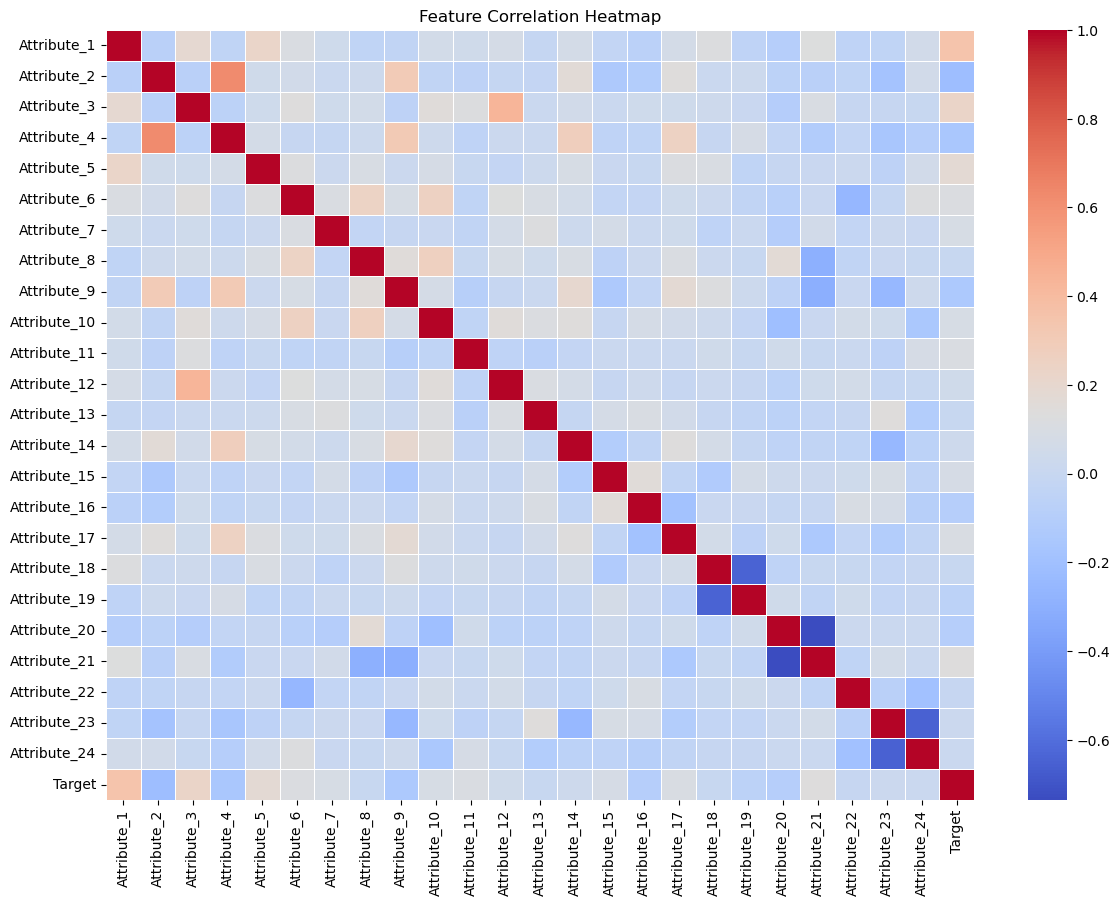

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()


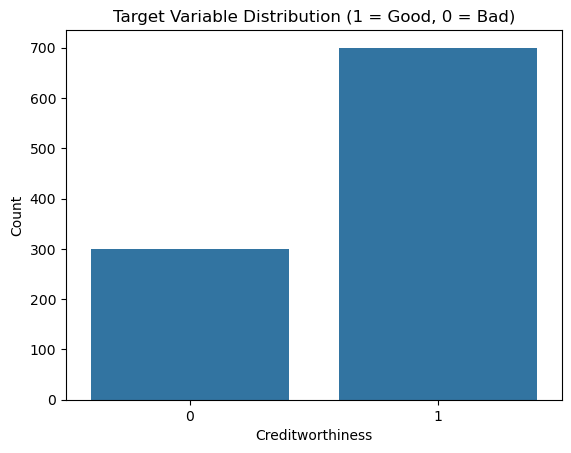

In [21]:
sns.countplot(x='Target', data=df)
plt.title('Target Variable Distribution (1 = Good, 0 = Bad)')
plt.xlabel('Creditworthiness')
plt.ylabel('Count')
plt.show()


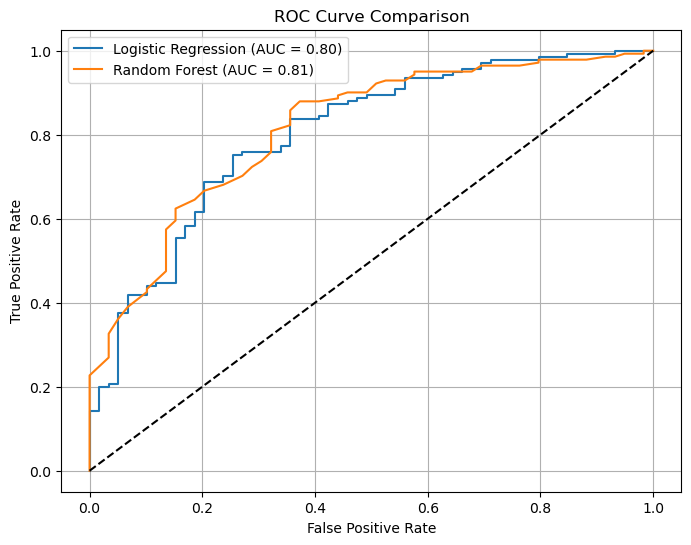

In [23]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X_test, y_test, label):
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc_score:.2f})")

plt.figure(figsize=(8, 6))
plot_roc_curve(lr, X_test, y_test, 'Logistic Regression')
plot_roc_curve(rf, X_test, y_test, 'Random Forest')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


In [26]:
from sklearn.model_selection import GridSearchCV

# Set up parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Initialize Grid Search
grid_search = GridSearchCV(estimator=RandomForestClassifier(), 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1,
                           scoring='roc_auc')

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best AUC Score:", grid_search.best_score_)

# Use the best estimator
best_rf = grid_search.best_estimator_

# Evaluate on test set
y_pred_best = best_rf.predict(X_test)
print(classification_report(y_test, y_pred_best))
print("ROC AUC (Tuned RF):", roc_auc_score(y_test, best_rf.predict_proba(X_test)[:, 1]))


Best Parameters: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best AUC Score: 0.7991525326346756
              precision    recall  f1-score   support

           0       0.77      0.41      0.53        59
           1       0.79      0.95      0.86       141

    accuracy                           0.79       200
   macro avg       0.78      0.68      0.70       200
weighted avg       0.79      0.79      0.77       200

ROC AUC (Tuned RF): 0.8219737949272748
